In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
num_epochs = 100

batch_size = 128

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download=True)
test_dataset =  torchvision.datasets.CIFAR10(root= './data', train = False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class_names = train_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
img, label = train_dataset[0]
img, label

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

Text(0.5, 1.0, 'frog')

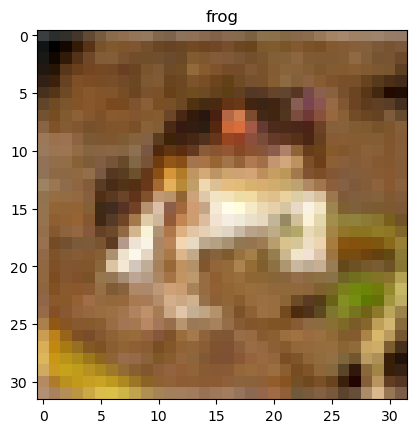

In [7]:
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.title(f"{class_names[label]}")

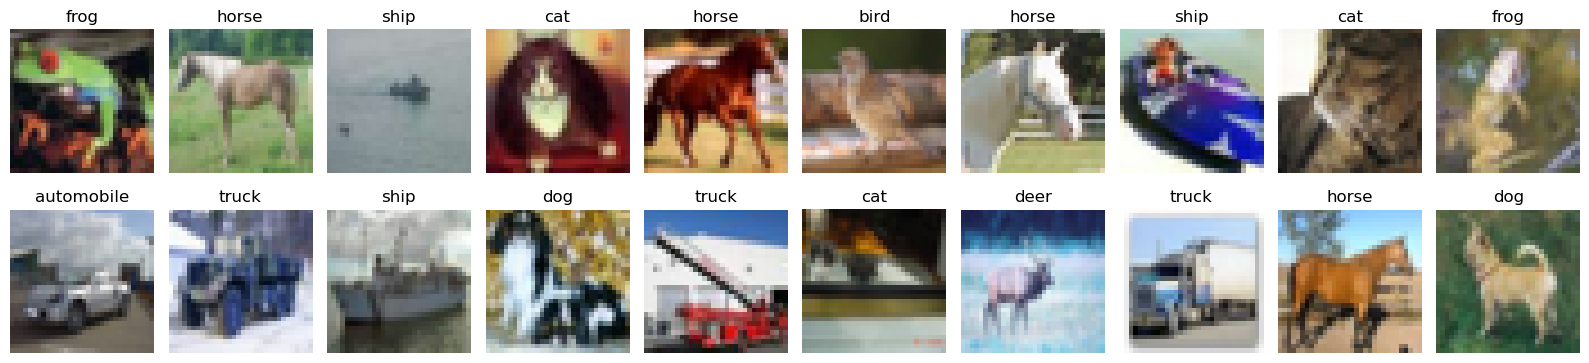

In [11]:
import torch
torch.manual_seed(42)     # Search on the internet why '42' is special or
                          # even '42 * 2' = 84

fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()

In [16]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
cifar_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,])

In [19]:
train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download=False, transform = cifar_transforms)
test_dataset =  torchvision.datasets.CIFAR10(root= './data', train = False, download=False, transform = cifar_transforms)

In [21]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset = train_dataset, lengths = [train_size, val_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(45000, 5000, 10000)

In [23]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset =train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset= test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle=True)

In [25]:
import math
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG,self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg):
    layers = []
    in_channels =3
    for out_channels in cfg:
        if out_channels == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2, stride =2)]
        else:
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding =1)
            layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = out_channels
    return nn.Sequential(*layers)

cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

def vgg16():
    return VGG(make_layers(cfg))

In [27]:
model = vgg16()

In [29]:
from torchmetrics import Accuracy
model = vgg16()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum = 0.9, weight_decay = 5e-4)
accuracy = Accuracy(task='multiclass', num_classes=10)

In [16]:
# from tqdm.notebook import tqdm
# # torch.cuda.empty_cache()
# # device-agnostic setup
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# accuracy = accuracy.to(device)
# model = model.to(device)

# for epoch in tqdm(range(num_epochs)):
#     # torch.cuda.empty_cache()
#     # Training loop
#     train_loss, train_acc = 0.0, 0.0
#     for X, y in train_dataloader:
#         X, y = X.to(device), y.to(device)
        
#         model.train()
        
#         y_pred = model(X)
        
#         loss = loss_fn(y_pred, y)
#         train_loss += loss.item()
        
#         acc = accuracy(y_pred, y)
#         train_acc += acc
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#     train_loss /= len(train_dataloader)
#     train_acc /= len(train_dataloader)
        
#     # Validation loop
#     val_loss, val_acc = 0.0, 0.0
#     model.eval()
#     with torch.inference_mode():
#         for X, y in val_dataloader:
#             X, y = X.to(device), y.to(device)
            
#             y_pred = model(X)
            
#             loss = loss_fn(y_pred, y)
#             val_loss += loss.item()
            
#             acc = accuracy(y_pred, y)
#             val_acc += acc
            
#         val_loss /= len(val_dataloader)
#         val_acc /= len(val_dataloader)
    
#     print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")
    

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  2.12092| Train acc:  0.16449| Val loss:  1.92737| Val acc:  0.20117
Epoch: 1| Train loss:  1.90712| Train acc:  0.22347| Val loss:  1.87025| Val acc:  0.25313
Epoch: 2| Train loss:  1.75012| Train acc:  0.30799| Val loss:  1.63132| Val acc:  0.35625
Epoch: 3| Train loss:  1.54617| Train acc:  0.40361| Val loss:  1.49851| Val acc:  0.42051
Epoch: 4| Train loss:  1.39028| Train acc:  0.48640| Val loss:  1.25027| Val acc:  0.55937
Epoch: 5| Train loss:  1.20277| Train acc:  0.57525| Val loss:  1.13054| Val acc:  0.60352
Epoch: 6| Train loss:  1.09389| Train acc:  0.62123| Val loss:  1.07125| Val acc:  0.64570
Epoch: 7| Train loss:  0.97957| Train acc:  0.66779| Val loss:  0.94133| Val acc:  0.68828
Epoch: 8| Train loss:  0.90979| Train acc:  0.69714| Val loss:  0.94703| Val acc:  0.68359
Epoch: 9| Train loss:  0.85398| Train acc:  0.71859| Val loss:  0.83533| Val acc:  0.72852
Epoch: 10| Train loss:  0.77885| Train acc:  0.74948| Val loss:  0.82425| Val acc:  0.7287

In [31]:
def count_params(model):
    total_params = 0
    for layer_names, param in model.named_parameters():
        total_params += torch.count_nonzero(param.data)
    return total_params

In [33]:
orig_params = count_params(model)
print(f"Unpruned LeNet-5 model has {orig_params} trainable parameters")

Unpruned LeNet-5 model has 15240906 trainable parameters


In [35]:
for layer, param in model.named_parameters():
    print(f"layer.name: {layer} & param.shape = {param.shape}")

layer.name: features.0.weight & param.shape = torch.Size([64, 3, 3, 3])
layer.name: features.0.bias & param.shape = torch.Size([64])
layer.name: features.2.weight & param.shape = torch.Size([64, 64, 3, 3])
layer.name: features.2.bias & param.shape = torch.Size([64])
layer.name: features.5.weight & param.shape = torch.Size([128, 64, 3, 3])
layer.name: features.5.bias & param.shape = torch.Size([128])
layer.name: features.7.weight & param.shape = torch.Size([128, 128, 3, 3])
layer.name: features.7.bias & param.shape = torch.Size([128])
layer.name: features.10.weight & param.shape = torch.Size([256, 128, 3, 3])
layer.name: features.10.bias & param.shape = torch.Size([256])
layer.name: features.12.weight & param.shape = torch.Size([256, 256, 3, 3])
layer.name: features.12.bias & param.shape = torch.Size([256])
layer.name: features.14.weight & param.shape = torch.Size([256, 256, 3, 3])
layer.name: features.14.bias & param.shape = torch.Size([256])
layer.name: features.17.weight & param.shap

In [37]:
for layer_name in model.state_dict().keys():
    print(layer_name, model.state_dict()[layer_name].shape)

features.0.weight torch.Size([64, 3, 3, 3])
features.0.bias torch.Size([64])
features.2.weight torch.Size([64, 64, 3, 3])
features.2.bias torch.Size([64])
features.5.weight torch.Size([128, 64, 3, 3])
features.5.bias torch.Size([128])
features.7.weight torch.Size([128, 128, 3, 3])
features.7.bias torch.Size([128])
features.10.weight torch.Size([256, 128, 3, 3])
features.10.bias torch.Size([256])
features.12.weight torch.Size([256, 256, 3, 3])
features.12.bias torch.Size([256])
features.14.weight torch.Size([256, 256, 3, 3])
features.14.bias torch.Size([256])
features.17.weight torch.Size([512, 256, 3, 3])
features.17.bias torch.Size([512])
features.19.weight torch.Size([512, 512, 3, 3])
features.19.bias torch.Size([512])
features.21.weight torch.Size([512, 512, 3, 3])
features.21.bias torch.Size([512])
features.24.weight torch.Size([512, 512, 3, 3])
features.24.bias torch.Size([512])
features.26.weight torch.Size([512, 512, 3, 3])
features.26.bias torch.Size([512])
features.28.weight t

In [39]:
model.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [41]:
def compute_sparsity(model):
    conv1_sparsity = (torch.sum(model.features[0].weight == 0) / model.features[0].weight.nelement()) * 100
    conv2_sparsity = (torch.sum(model.features[2].weight == 0) / model.features[2].weight.nelement()) * 100
    conv3_sparsity = (torch.sum(model.features[5].weight == 0) / model.features[5].weight.nelement()) * 100
    conv4_sparsity = (torch.sum(model.features[7].weight == 0) / model.features[7].weight.nelement()) * 100
    conv5_sparsity = (torch.sum(model.features[10].weight == 0) / model.features[10].weight.nelement()) * 100
    conv6_sparsity = (torch.sum(model.features[12].weight == 0) / model.features[12].weight.nelement()) * 100
    conv7_sparsity = (torch.sum(model.features[14].weight == 0) / model.features[14].weight.nelement()) * 100
    conv8_sparsity = (torch.sum(model.features[17].weight == 0) / model.features[17].weight.nelement()) * 100
    conv9_sparsity = (torch.sum(model.features[19].weight == 0) / model.features[19].weight.nelement()) * 100
    conv10_sparsity = (torch.sum(model.features[21].weight == 0) / model.features[21].weight.nelement()) * 100
    conv11_sparsity = (torch.sum(model.features[24].weight == 0) / model.features[24].weight.nelement()) * 100
    conv12_sparsity = (torch.sum(model.features[26].weight == 0) / model.features[26].weight.nelement()) * 100
    conv13_sparsity = (torch.sum(model.features[28].weight == 0) / model.features[28].weight.nelement()) * 100
    fc1_sparsity = (torch.sum(model.classifier[1].weight == 0) / model.classifier[1].weight.nelement()) * 100
    fc2_sparsity = (torch.sum(model.classifier[4].weight == 0) / model.classifier[4].weight.nelement()) * 100
    op_sparsity = (torch.sum(model.classifier[6].weight == 0) / model.classifier[6].weight.nelement()) * 100

    num = torch.sum(model.features[0].weight == 0) + torch.sum(model.features[2].weight == 0) + torch.sum(model.features[5].weight == 0) + torch.sum(model.features[7].weight == 0) + torch.sum(model.features[10].weight == 0) + torch.sum(model.features[12].weight == 0) + torch.sum(model.features[14].weight == 0) + torch.sum(model.features[17].weight == 0) + torch.sum(model.features[19].weight == 0) + torch.sum(model.features[21].weight == 0)+ torch.sum(model.features[24].weight == 0) + torch.sum(model.features[26].weight == 0) + torch.sum(model.features[28].weight == 0) + torch.sum(model.classifier[1].weight == 0) + torch.sum(model.classifier[4].weight == 0) + torch.sum(model.classifier[6].weight == 0)
    denom = model.features[0].weight.nelement() + model.features[2].weight.nelement() + model.features[5].weight.nelement() + model.features[7].weight.nelement() + model.features[10].weight.nelement() + model.features[12].weight.nelement() + model.features[14].weight.nelement() + model.features[17].weight.nelement() + model.features[19].weight.nelement() + model.features[21].weight.nelement() + model.features[24].weight.nelement() + model.features[26].weight.nelement() + model.features[28].weight.nelement() + model.classifier[1].weight.nelement() + model.classifier[4].weight.nelement() + model.classifier[6].weight.nelement()
    global_sparsity = num/denom * 100
    return global_sparsity

In [43]:
print(f"LeNet-5 global sparsity = {compute_sparsity(model):.2f}%")

LeNet-5 global sparsity = 0.00%


In [45]:
import torch.nn.utils.prune as prune
from tqdm.notebook import tqdm
# torch.cuda.empty_cache()
# device-agnostic setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
accuracy = accuracy.to(device)
model = model.to(device)
for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")

    prune.ln_structured(model.features[0], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[2], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[5], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[7], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[10], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[12], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[14], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[17], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[19], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[21], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[24], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[26], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[28], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.classifier[1], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.classifier[4], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.classifier[6], name = "weight", amount = 0.1, n = 2, dim = 0)

    # Print current global sparsity level-
    print(f"LeNet-5 global sparsity = {compute_sparsity(model):.2f}%")
    # Fine-training loop-
    print("\nFine-tuning pruned model to recover model's performance\n")

    for epoch in tqdm(range(num_epochs)):
        # torch.cuda.empty_cache()
        # Training loop
        train_loss, train_acc = 0.0, 0.0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            
            model.train()
            
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            
            acc = accuracy(y_pred, y)
            train_acc += acc
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
            
        # Validation loop
        val_loss, val_acc = 0.0, 0.0
        model.eval()
        with torch.inference_mode():
            for X, y in val_dataloader:
                X, y = X.to(device), y.to(device)
                
                y_pred = model(X)
                
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
                
                acc = accuracy(y_pred, y)
                val_acc += acc
                
            val_loss /= len(val_dataloader)
            val_acc /= len(val_dataloader)
        
        print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")
    



Iterative Global pruning round = 1
LeNet-5 global sparsity = 9.98%

Fine-tuning pruned model to recover model's performance



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  2.10959| Train acc:  0.16795| Val loss:  1.97974| Val acc:  0.19902
Epoch: 1| Train loss:  1.91856| Train acc:  0.22330| Val loss:  1.87519| Val acc:  0.20938
Epoch: 2| Train loss:  1.75344| Train acc:  0.30214| Val loss:  1.64999| Val acc:  0.32559
Epoch: 3| Train loss:  1.56175| Train acc:  0.39770| Val loss:  1.38871| Val acc:  0.47715
Epoch: 4| Train loss:  1.36547| Train acc:  0.49527| Val loss:  1.26611| Val acc:  0.55313
Epoch: 5| Train loss:  1.21138| Train acc:  0.57094| Val loss:  1.16926| Val acc:  0.58809
Epoch: 6| Train loss:  1.06923| Train acc:  0.63300| Val loss:  1.03598| Val acc:  0.64199
Epoch: 7| Train loss:  0.98219| Train acc:  0.66769| Val loss:  1.00347| Val acc:  0.66172
Epoch: 8| Train loss:  0.90893| Train acc:  0.69663| Val loss:  0.86829| Val acc:  0.71074
Epoch: 9| Train loss:  0.86495| Train acc:  0.71301| Val loss:  0.82613| Val acc:  0.72148
Epoch: 10| Train loss:  0.79898| Train acc:  0.73921| Val loss:  0.81865| Val acc:  0.7259

In [47]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "vgg_16_cifar_pruned.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model
print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

# Loading the saved model
model_vgg_16_cifar_prune_loaded = vgg16()

prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[0], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[2], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[5], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[7], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[10], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[12], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[14], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[17], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[19], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[21], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[24], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[26], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.features[28], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.classifier[1], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.classifier[4], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_vgg_16_cifar_prune_loaded.classifier[6], name = "weight", amount = 0.1, n = 2, dim = 0)

model_vgg_16_cifar_prune_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))


Saving the model: models\vgg_16_cifar_pruned.pth


C:\Users\User\AppData\Local\Temp\ipykernel_17648\833682548.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vgg_16_cifar_prune_loaded.load_state_dict(torch.load(MO

<All keys matched successfully>

In [49]:
test_loss, test_acc = 0, 0

model_vgg_16_cifar_prune_loaded.to(device)

model_vgg_16_cifar_prune_loaded.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model_vgg_16_cifar_prune_loaded(X)
        
        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)
        
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

Test loss:  0.45236| Test acc:  0.86066
